In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


2024-12-04 14:43:15.430551: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 14:43:15.440238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 14:43:15.452603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 14:43:15.456379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 14:43:15.466000: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# same as BERT_Test_1_sun.ipynb but added code to remove http:// and https://
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar

In [8]:
# Load the original CSV file
file_path = "tturls_aug1.csv"
df = pd.read_csv(file_path)
df['label'].value_counts()

label
legitimate    4000
phishing      1000
Name: count, dtype: int64

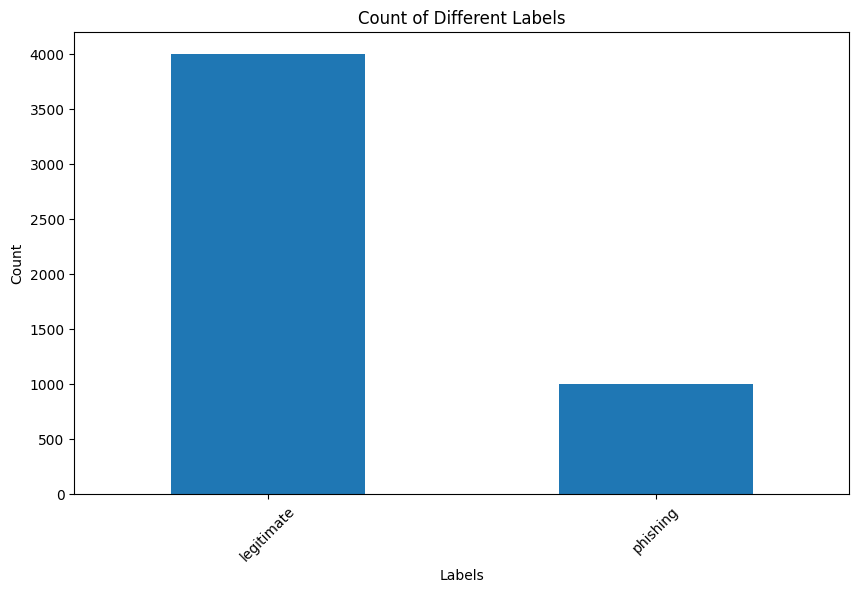

In [9]:
import matplotlib.pyplot as plt

# Count the number of different labels
label_counts = df['label'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Count of Different Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [7]:
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.optim import AdamW
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


# Load the dataset
df = pd.read_csv('tturls_aug1.csv')  # Replace with your dataset path
print("Dataset loaded.")

# Encode the labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])  # 'legitimate' -> 0, 'phishing' -> 1
print("Labels encoded.")

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("Tokenizer loaded.")

# Define the custom Dataset class
class URLDataset(Dataset):
    def __init__(self, urls, labels, tokenizer, max_length=128):
        self.urls = urls
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = str(self.urls[idx])
        label = self.labels[idx]

        # Remove 'http://' or 'https://' from the URL
        if url.startswith("http://"):
            url = url[7:]  # Remove 'http://'
        elif url.startswith("https://"):
            url = url[8:]  # Remove 'https://'

        # Remove 'www.' if it exists
        if url.startswith("www."):
            url = url[4:]  # Remove 'www.'

        # Tokenize the URL
        encoding = self.tokenizer.encode_plus(
            url,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        inputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        return inputs

print("Dataset class defined.")

# Split the dataset into training and validation sets
train_urls, val_urls, train_labels, val_labels = train_test_split(
    df['url'], df['label_encoded'], test_size=0.1, random_state=42
)
print("Dataset split into training and validation sets.")

# Create Dataset instances
train_dataset = URLDataset(train_urls.values, train_labels.values, tokenizer)
val_dataset = URLDataset(val_urls.values, val_labels.values, tokenizer)
print("Dataset instances created.")

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
print("DataLoader instances created.")

# Initialize the BERT configuration
config = BertConfig(
    vocab_size=30522,  # Default vocab size for BERT
    hidden_size=768,  # Hidden size of BERT layers
    num_attention_heads=12,  # Number of attention heads in BERT
    num_hidden_layers=12,  # Number of layers in BERT
    intermediate_size=3072,  # Size of the intermediate feed-forward layers
    max_position_embeddings=512,  # Maximum sequence length
    num_labels=2,  # Number of output classes (phishing, legitimate)
)

# Initialize the BERT model from scratch
model = BertForSequenceClassification(config)
print("Model initialized.")

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")

# Define the optimizer
#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(model.parameters(), lr=2e-5)


# Training parameters
epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    print(f'\nEpoch {epoch+1}/{epochs}')
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_train_examples = 0

    # Using tqdm to show the progress bar for training
    for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}", unit="batch")):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct = torch.sum(preds == labels)
        total_train_correct += correct.item()
        total_train_examples += labels.size(0)

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_examples

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Train loss: {avg_train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')

    # Validation
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_examples = 0


    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct = torch.sum(preds == labels)
            total_val_correct += correct.item()
            total_val_examples += labels.size(0)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / total_val_examples

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}')



Dataset loaded.
Labels encoded.
Tokenizer loaded.
Dataset class defined.
Dataset split into training and validation sets.
Dataset instances created.
DataLoader instances created.
Model initialized.
Using device: cuda

Epoch 1/15


Training Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:33<00:00,  4.20batch/s]


Train loss: 0.5087, Train accuracy: 0.7956


Validation Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.47batch/s]


Validation loss: 0.5178, Validation accuracy: 0.8020

Epoch 2/15


Training Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:35<00:00,  3.98batch/s]


Train loss: 0.3643, Train accuracy: 0.8438


Validation Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s]


Validation loss: 0.3988, Validation accuracy: 0.8780

Epoch 3/15


Training Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:35<00:00,  3.96batch/s]


Train loss: 0.1973, Train accuracy: 0.9247


Validation Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s]


Validation loss: 0.1837, Validation accuracy: 0.9320

Epoch 4/15


Training Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.06batch/s]


Train loss: 0.1292, Train accuracy: 0.9560


Validation Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.35batch/s]


Validation loss: 0.2253, Validation accuracy: 0.9180

Epoch 5/15


Training Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.08batch/s]


Train loss: 0.0982, Train accuracy: 0.9644


Validation Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.28batch/s]


Validation loss: 0.1989, Validation accuracy: 0.9400

Epoch 6/15


Training Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.04batch/s]


Train loss: 0.0557, Train accuracy: 0.9822


Validation Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.19batch/s]


Validation loss: 0.2147, Validation accuracy: 0.9440

Epoch 7/15


Training Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.04batch/s]


Train loss: 0.0571, Train accuracy: 0.9809


Validation Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.28batch/s]


Validation loss: 0.2521, Validation accuracy: 0.9340

Epoch 8/15


Training Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.04batch/s]


Train loss: 0.0253, Train accuracy: 0.9933


Validation Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.28batch/s]


Validation loss: 0.2410, Validation accuracy: 0.9380

Epoch 9/15


Training Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:35<00:00,  4.01batch/s]


Train loss: 0.0314, Train accuracy: 0.9918


Validation Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.25batch/s]


Validation loss: 0.2583, Validation accuracy: 0.9400

Epoch 10/15


Training Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:35<00:00,  4.01batch/s]


Train loss: 0.0168, Train accuracy: 0.9960


Validation Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.32batch/s]


Validation loss: 0.2865, Validation accuracy: 0.9320

Epoch 11/15


Training Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.08batch/s]


Train loss: 0.0119, Train accuracy: 0.9962


Validation Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.98batch/s]


Validation loss: 0.2664, Validation accuracy: 0.9460

Epoch 12/15


Training Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:35<00:00,  4.00batch/s]


Train loss: 0.0135, Train accuracy: 0.9962


Validation Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s]


Validation loss: 0.2319, Validation accuracy: 0.9540

Epoch 13/15


Training Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.11batch/s]


Train loss: 0.0138, Train accuracy: 0.9969


Validation Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.65batch/s]


Validation loss: 0.2451, Validation accuracy: 0.9480

Epoch 14/15


Training Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.08batch/s]


Train loss: 0.0266, Train accuracy: 0.9898


Validation Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.49batch/s]


Validation loss: 0.2251, Validation accuracy: 0.9540

Epoch 15/15


Training Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:34<00:00,  4.05batch/s]


Train loss: 0.0124, Train accuracy: 0.9967


Validation Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.50batch/s]

Validation loss: 0.2782, Validation accuracy: 0.9540


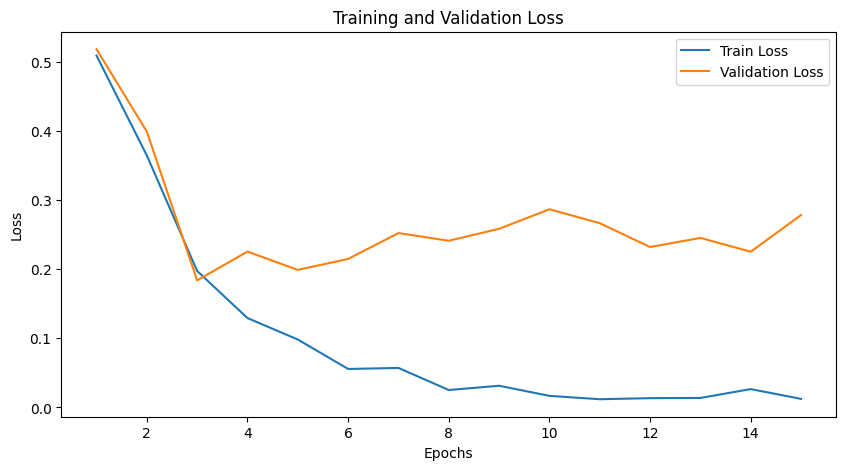

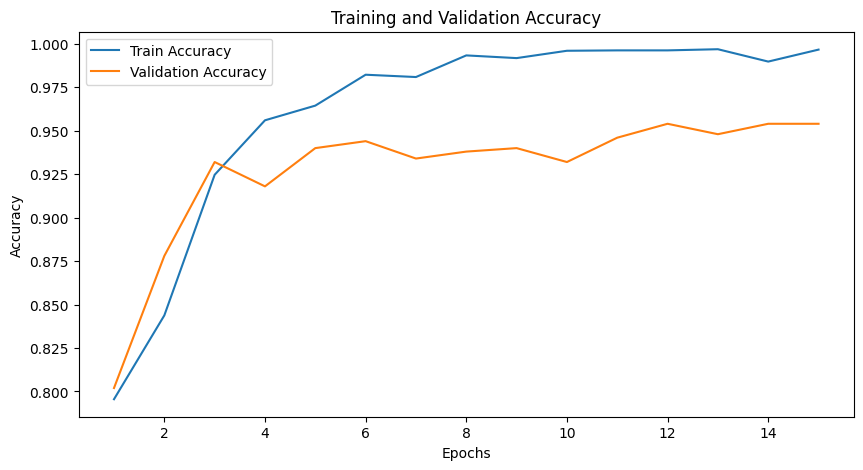

In [10]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy over epochs
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
********************************Testing***********************************

In [28]:
# Load the test dataset
test_df = pd.read_csv('test_tturls.csv')  # Replace with your test set file path
print("Test dataset loaded.")
label_counts = test_df['label'].value_counts()
print(label_counts)

Test dataset loaded.
label
phishing      10000
legitimate    10000
Name: count, dtype: int64


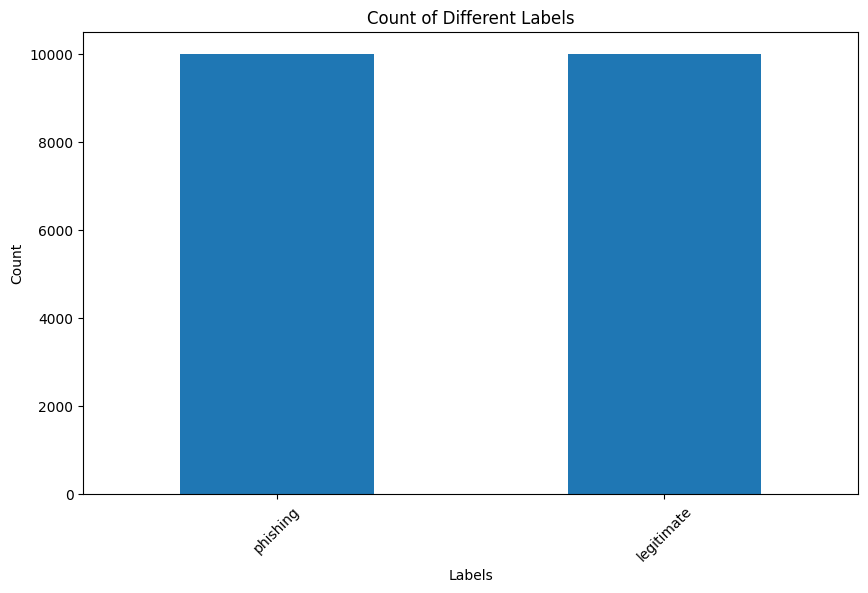

In [29]:
import matplotlib.pyplot as plt

# Count the number of different labels
label_counts = test_df['label'].value_counts()

# Plot the counts
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Count of Different Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:52<00:00, 11.87batch/s]


Test Accuracy: 88.82%
Precision: 0.98
Recall: 0.80
F1 Score: 0.88


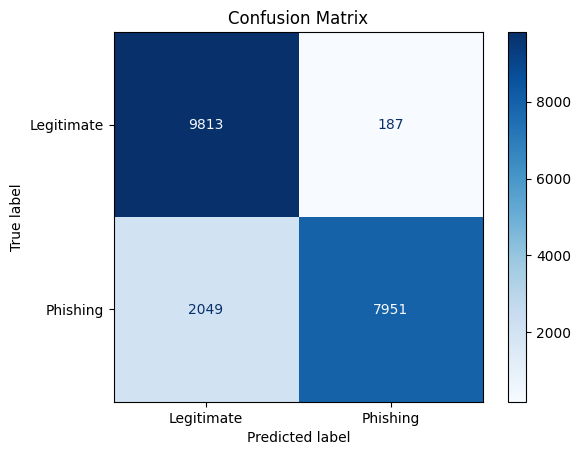

In [30]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()  # Set model to evaluation mode

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the custom Dataset class for test data
class URLDataset(Dataset):
    def __init__(self, urls, labels, tokenizer, max_length=128):
        self.urls = urls
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = str(self.urls[idx])
        label = self.labels[idx]

        # Convert label to integer if it's a string (e.g., 'phishing' -> 1, 'legitimate' -> 0)
        if label == 'phishing':
            label = 1
        elif label == 'legitimate':
            label = 0
        else:
            raise ValueError(f"Unknown label: {label}")

        # Remove 'http://' or 'https://' from the URL
        if url.startswith("http://"):
            url = url[7:]  # Remove 'http://'
        elif url.startswith("https://"):
            url = url[8:]  # Remove 'https://'

        # Remove 'www.' if it exists
        if url.startswith("www."):
            url = url[4:]  # Remove 'www.'

        # Tokenize the URL
        encoding = self.tokenizer.encode_plus(
            url,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        inputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        return inputs

# Create Dataset instance for the test set
test_dataset = URLDataset(test_df['url'].values, test_df['label'].values, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test set
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation for inference
    for batch in tqdm(test_loader, desc="Testing", unit="batch"):
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions
        _, preds = torch.max(logits, dim=1)

        # Store the predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate additional metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
